# Step 1: Setup - Importing Libraries

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imaja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 2: Loading the data set

In [72]:
file_path = r"https://raw.githubusercontent.com/ajayt0m/Text_Classification_Alleppey/main/WScraped.csv"

# Try reading the CSV file with 'latin1' encoding
df = pd.read_csv(file_path, encoding='latin1')

In [3]:
with pd.option_context("display.max_columns", None, "display.max_rows", None):
    display(df.head())

,Id,Title,Review,Label
0,1,Most overrated destination in kerala,I had a high expectations seeing this place in...,2
1,2,Venice of the East,Popularly known as'Venice of the East' Alleppe...,3
2,3,Alleppey is most polluted city,"Hai friends, today I am telling you my bad exp...",1
3,4,Alleppey,Alleppey is one the best place to visit in Ker...,4
4,5,ABOUT EXPENSIVE ALLEPPEY TRIP,Alleppey one of the famous district in kerala....,1


In [74]:
df

,Id,Title,Review,Label
0,1,Most overrated destination in kerala,I had a high expectations seeing this place in...,2
1,2,Venice of the East,Popularly known as'Venice of the East' Alleppe...,3
2,3,Alleppey is most polluted city,"Hai friends, today I am telling you my bad exp...",1
3,4,Alleppey,Alleppey is one the best place to visit in Ker...,4
4,5,ABOUT EXPENSIVE ALLEPPEY TRIP,Alleppey one of the famous district in kerala....,1
...,...,...,...,...
95,96,NaN,Beach was good and clean. We went early in the...,5
96,97,NaN,"Badly kept beach, authorities have no concern ...",1
97,98,NaN,"Nice beach, best to visit early morning. Most ...",3
98,99,NaN,Alappuzha Beach is known for its picturesque b...,4


# Step 3: Data Transformation

In [4]:
#1. Feature Engineering - Merge Title and review 
# Fill NaN values in 'Title' column with an empty string
df['Title'].fillna('', inplace=True)

# Create a new column 'Title_Review' by concatenating 'Title' and 'Review'
df['Title_Review'] = df['Title'] + '. ' + df['Review']

In [5]:
#2. Feature Engineering - Creating new labels
# Define a function to simplify the labels
def simplify_label(label):
    if label in [4, 5]:
        return 'Happy Visit'
    elif label == 3:
        return 'Ok Visit'
    elif label in [1, 2]:
        return 'Bad Visit'
    else:
        return 'Unknown'  # You can adjust this based on your specific needs

# Apply the function to create the new column 'Label_simplified'
df['Label_simplified'] = df['Label'].apply(simplify_label)

In [6]:
with pd.option_context("display.max_columns", None, "display.max_rows", None):
    display(df.head())

,Id,Title,Review,Label,Title_Review,Label_simplified
0,1,Most overrated destination in kerala,I had a high expectations seeing this place in...,2,Most overrated destination in kerala. I had a ...,Bad Visit
1,2,Venice of the East,Popularly known as'Venice of the East' Alleppe...,3,Venice of the East. Popularly known as'Venice ...,Ok Visit
2,3,Alleppey is most polluted city,"Hai friends, today I am telling you my bad exp...",1,"Alleppey is most polluted city. Hai friends, t...",Bad Visit
3,4,Alleppey,Alleppey is one the best place to visit in Ker...,4,Alleppey. Alleppey is one the best place to vi...,Happy Visit
4,5,ABOUT EXPENSIVE ALLEPPEY TRIP,Alleppey one of the famous district in kerala....,1,ABOUT EXPENSIVE ALLEPPEY TRIP. Alleppey one of...,Bad Visit


## Step 4: Exploratory Data Analysis

Happy Visit    66
Bad Visit      21
Ok Visit       13
Name: Label_simplified, dtype: int64


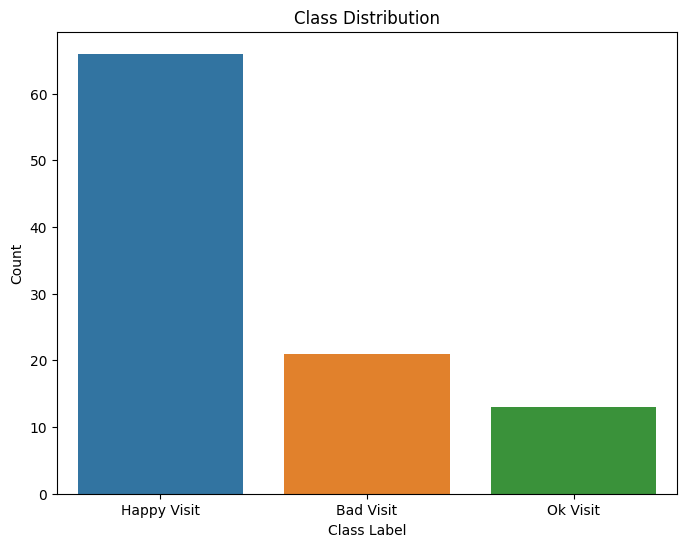

In [7]:
#1. Class Distribution
x=df['Label_simplified'].value_counts()
print(x)

# Check the class distribution
class_distribution = df['Label_simplified'].value_counts()

# Plotting the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [8]:
#2. Missing Values
df.isna().sum()

Id                  0
Title               0
Review              0
Label               0
Title_Review        0
Label_simplified    0
dtype: int64

In [9]:
#3. Word Count - Number of words in each review
df['word_count'] = df['Title_Review'].apply(lambda x: len(str(x).split()))
print(df[df['Label_simplified']=='Happy Visit']['word_count'].mean()) #Happy Visit
print(df[df['Label_simplified']=='Bad Visit']['word_count'].mean()) #Bad Visit
print(df[df['Label_simplified']=='Ok Visit']['word_count'].mean()) #Ok Visit

225.25757575757575
310.8095238095238
115.46153846153847


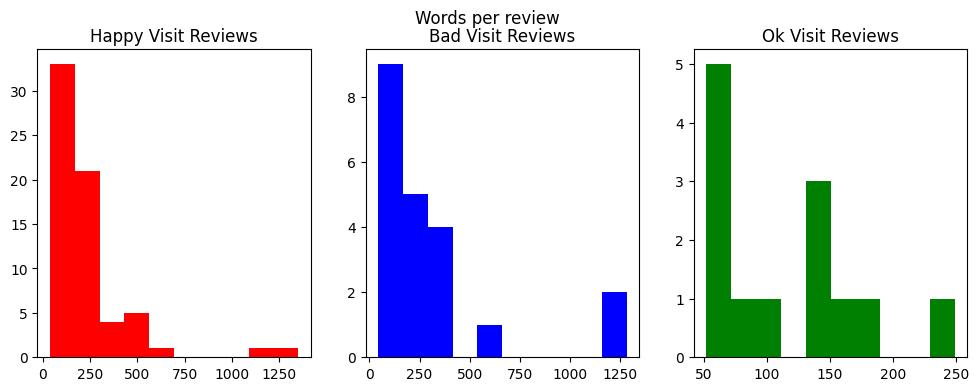

In [10]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

words=df[df['Label_simplified']=='Happy Visit']['word_count']
ax1.hist(words,color='red')
ax1.set_title('Happy Visit Reviews')

words=df[df['Label_simplified']=='Bad Visit']['word_count']
ax2.hist(words,color='blue')
ax2.set_title('Bad Visit Reviews')

words=df[df['Label_simplified']=='Ok Visit']['word_count']
ax3.hist(words,color='green')
ax3.set_title('Ok Visit Reviews')

fig.suptitle('Words per review')
plt.show()

In [11]:
#4. Character Count - Number of characters in a review
df['char_count'] = df['Title_Review'].apply(lambda x: len(str(x)))
print(df[df['Label_simplified']=='Happy Visit']['char_count'].mean()) #Happy Visit
print(df[df['Label_simplified']=='Bad Visit']['char_count'].mean()) #Bad Visit
print(df[df['Label_simplified']=='Ok Visit']['char_count'].mean()) #Ok Visit

1273.1515151515152
1686.0
667.6153846153846


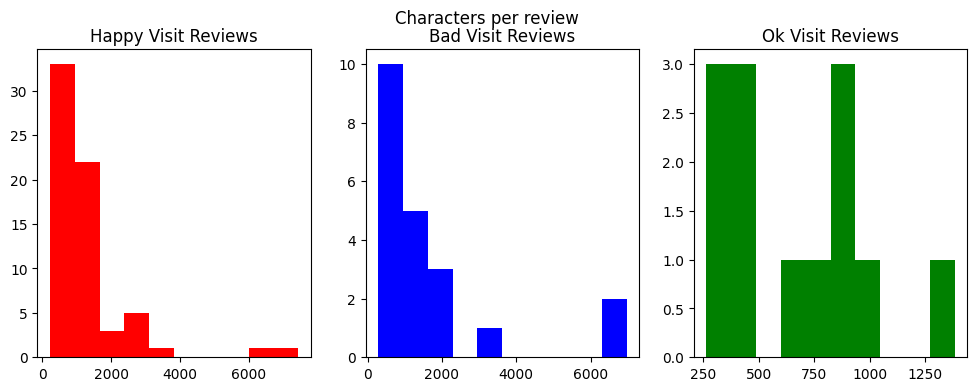

In [12]:
# PLOTTING Character Count
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))

words=df[df['Label_simplified']=='Happy Visit']['char_count']
ax1.hist(words,color='red')
ax1.set_title('Happy Visit Reviews')

words=df[df['Label_simplified']=='Bad Visit']['char_count']
ax2.hist(words,color='blue')
ax2.set_title('Bad Visit Reviews')

words=df[df['Label_simplified']=='Ok Visit']['char_count']
ax3.hist(words,color='green')
ax3.set_title('Ok Visit Reviews')

fig.suptitle('Characters per review')
plt.show()

# Step 5: Text Pre-Processing

In [13]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df['clean_text'] = df['Title_Review'].apply(lambda x: finalpreprocess(x))
df.head()

,Id,Title,Review,Label,Title_Review,Label_simplified,word_count,char_count,clean_text
0,1,Most overrated destination in kerala,I had a high expectations seeing this place in...,2,Most overrated destination in kerala. I had a ...,Bad Visit,48,282,overrate destination kerala high expectation s...
1,2,Venice of the East,Popularly known as'Venice of the East' Alleppe...,3,Venice of the East. Popularly known as'Venice ...,Ok Visit,149,904,venice east popularly know venice east alleppe...
2,3,Alleppey is most polluted city,"Hai friends, today I am telling you my bad exp...",1,"Alleppey is most polluted city. Hai friends, t...",Bad Visit,120,649,alleppey pollute city hai friend today tell ba...
3,4,Alleppey,Alleppey is one the best place to visit in Ker...,4,Alleppey. Alleppey is one the best place to vi...,Happy Visit,60,320,alleppey alleppey one best place visit kerala ...
4,5,ABOUT EXPENSIVE ALLEPPEY TRIP,Alleppey one of the famous district in kerala....,1,ABOUT EXPENSIVE ALLEPPEY TRIP. Alleppey one of...,Bad Visit,258,1434,expensive alleppey trip alleppey one famous di...


# Step 6: Extracting vectors from text (Vectorization)

In [45]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["Label_simplified"],test_size=0.33,random_state=42)

print('Training Data Shape: ', X_train.shape)
print('Training Label Shape: ', y_train.shape)
print('Testing Data Shape: ', X_test.shape)
print('Testing Label Shape: ', y_test.shape)

Training Data Shape:  (67,)
Training Label Shape:  (67,)
Testing Data Shape:  (33,)
Testing Label Shape:  (33,)


In [47]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [48]:
#Word2Vec
# Word2Vec runs on tokenized sentences
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
            return self

    def transform(self, X):
            return np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(self.dim)], axis=0)
                for words in X
            ])

df['clean_text_tok'] = [nltk.word_tokenize(i) for i in df['clean_text']]
model = Word2Vec(df['clean_text_tok'], min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

# Step 7: ML Models

## 7.1 Logistic Regression

In [49]:
#Class Imbalance Handling
# Compute class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(df['Label_simplified']), y=df['Label_simplified'])

# Create a dictionary to pass to the model
class_weight_dict = dict(zip(np.unique(df['Label_simplified']), class_weights))

In [50]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight=class_weight_dict)
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,y_predict))
conf_matrix = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n',conf_matrix)

              precision    recall  f1-score   support

   Bad Visit       1.00      0.25      0.40         8
 Happy Visit       0.69      0.95      0.80        21
    Ok Visit       0.50      0.25      0.33         4

    accuracy                           0.70        33
   macro avg       0.73      0.48      0.51        33
weighted avg       0.74      0.70      0.65        33

Confusion Matrix: 
 [[ 2  6  0]
 [ 0 20  1]
 [ 0  3  1]]


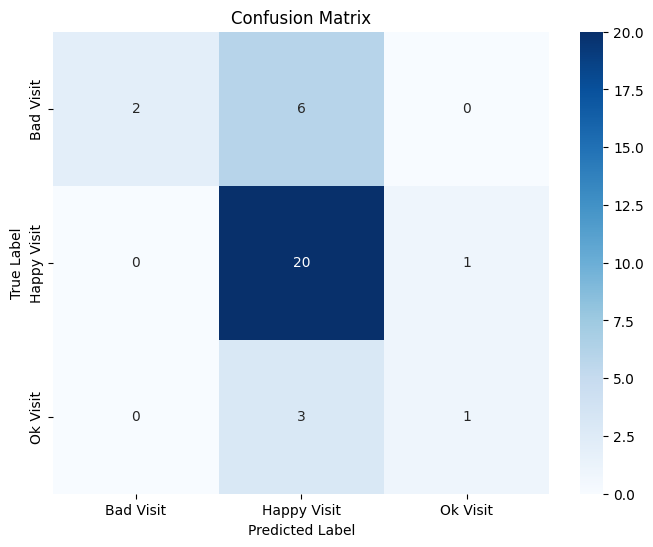

In [51]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr_tfidf.classes_, yticklabels=lr_tfidf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [65]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight=class_weight_dict)
lr_w2v.fit(X_train_vectors_w2v, y_train)

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,y_predict))
conf_matrix = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n',conf_matrix)

              precision    recall  f1-score   support

   Bad Visit       0.00      0.00      0.00         8
 Happy Visit       0.64      1.00      0.78        21
    Ok Visit       0.00      0.00      0.00         4

    accuracy                           0.64        33
   macro avg       0.21      0.33      0.26        33
weighted avg       0.40      0.64      0.49        33

Confusion Matrix: 
 [[ 0  8  0]
 [ 0 21  0]
 [ 0  4  0]]


d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


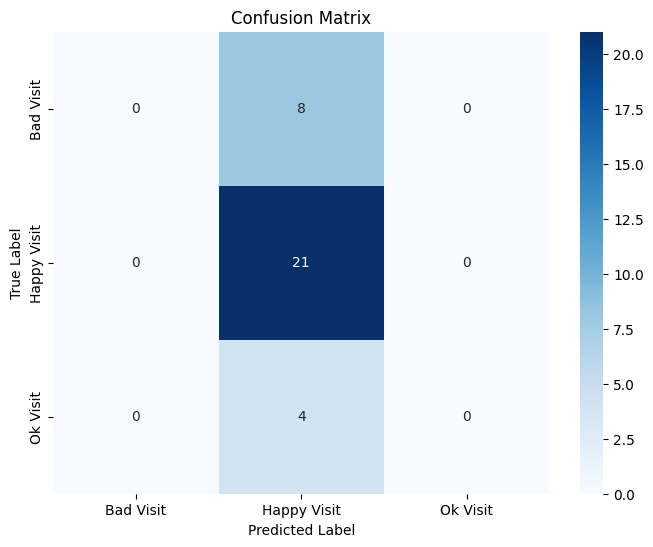

In [66]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr_w2v.classes_, yticklabels=lr_w2v.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7.2 Naive Bayes

In [54]:
# Class Imbalance Handling
# Calculate prior probabilities for each class
class_counts = y_train.value_counts()
class_priors = class_counts / class_counts.sum()

In [67]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB(class_prior=class_priors.values)
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
print(classification_report(y_test,y_predict))
conf_matrix = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n',conf_matrix)

              precision    recall  f1-score   support

   Bad Visit       0.39      0.88      0.54         8
 Happy Visit       0.80      0.57      0.67        21
    Ok Visit       0.00      0.00      0.00         4

    accuracy                           0.58        33
   macro avg       0.40      0.48      0.40        33
weighted avg       0.60      0.58      0.55        33

Confusion Matrix: 
 [[ 7  1  0]
 [ 9 12  0]
 [ 2  2  0]]


d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Softwares\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


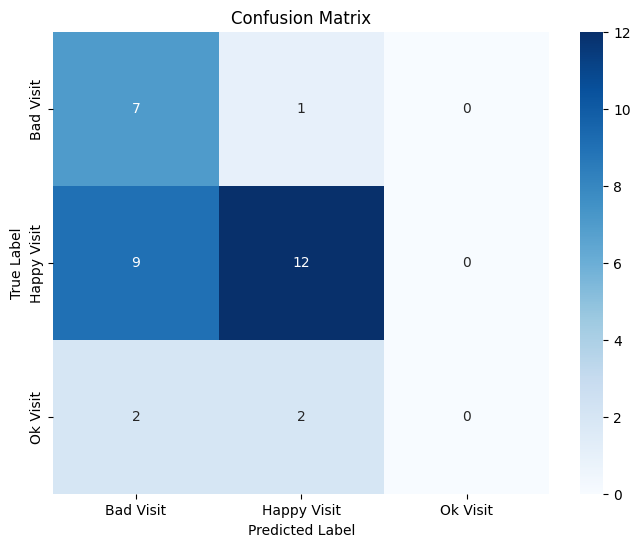

In [68]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, yticklabels=nb_tfidf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [62]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(W2v)
nb_w2v = GaussianNB(priors=class_priors.values)
nb_w2v.fit(X_train_vectors_w2v, y_train)  

#Predict y value for test dataset
y_predict = nb_w2v.predict(X_test_vectors_w2v)
print(classification_report(y_test,y_predict))
conf_matrix = confusion_matrix(y_test, y_predict)
print('Confusion Matrix: \n',conf_matrix)

              precision    recall  f1-score   support

   Bad Visit       0.25      0.12      0.17         8
 Happy Visit       0.75      0.43      0.55        21
    Ok Visit       0.12      0.50      0.19         4

    accuracy                           0.36        33
   macro avg       0.37      0.35      0.30        33
weighted avg       0.55      0.36      0.41        33

Confusion Matrix: 
 [[ 1  3  4]
 [ 1  9 11]
 [ 2  0  2]]


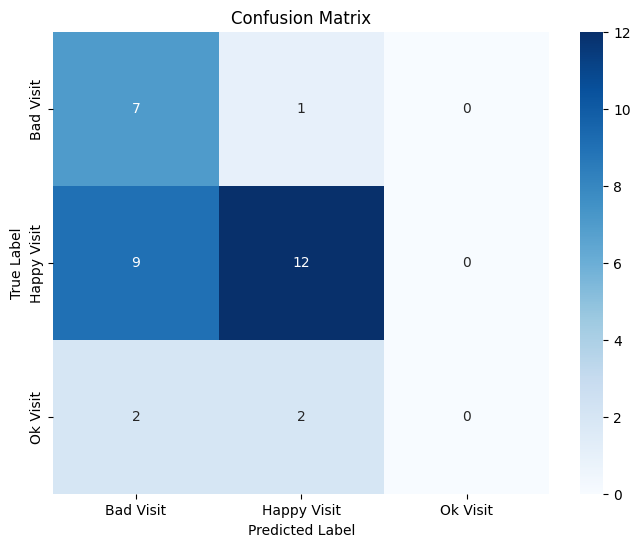

In [69]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_w2v.classes_, yticklabels=nb_w2v.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()